# Generate plots for README

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
seed = 42
rng = np.random.default_rng(seed)
image_path = "../_static/"

## ANCOVA

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


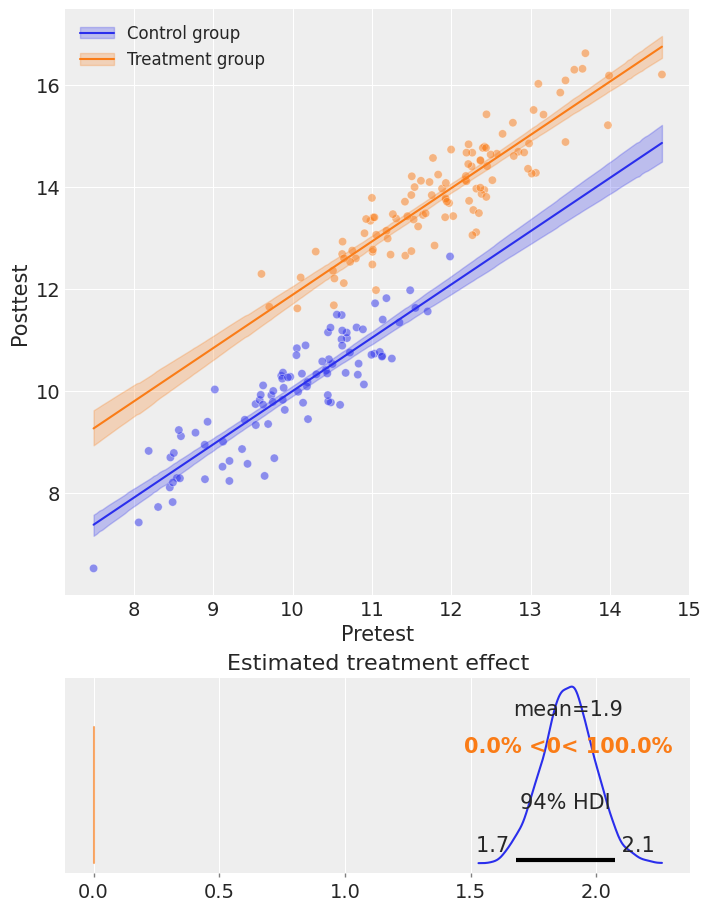

In [3]:
df = cp.load_data("anova1")
result = cp.pymc_experiments.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)
result.plot()
plt.savefig(image_path + "anova_pymc.svg", bbox_inches="tight", pad_inches=0.1)

## Difference in differences

In [4]:
df = cp.load_data("did")

In [5]:
result = cp.pymc_experiments.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group + t + group:post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
/Users/benjamv/git/CausalPy/causalpy/pymc_experiments.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_x.iloc[:, i] = 0
Sampling: [y_hat]


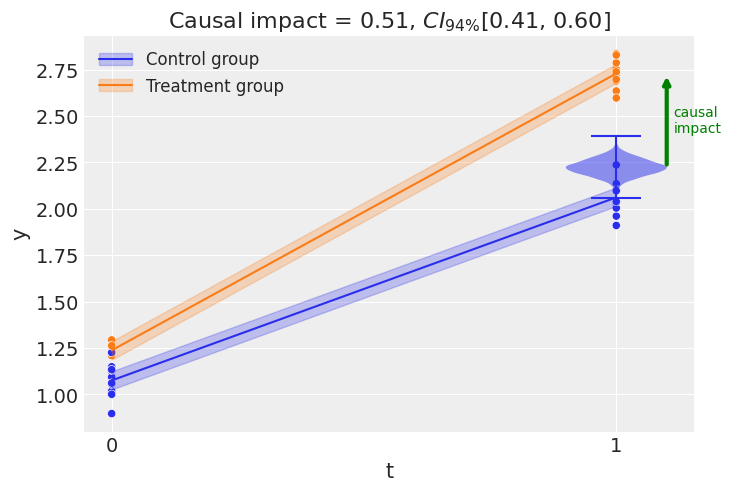

In [6]:
fig, ax = result.plot()
plt.savefig(
    image_path + "difference_in_differences_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

## Regression discontinuity

In [7]:
df = cp.load_data("rd")

In [8]:
result = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


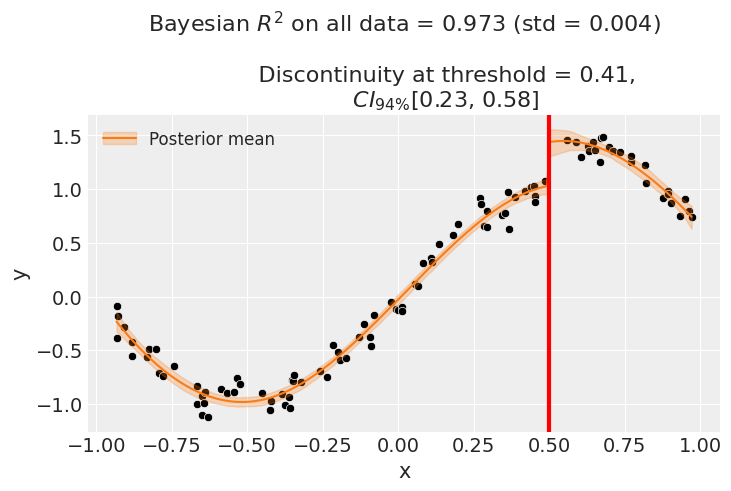

In [9]:
fig, ax = result.plot()
plt.savefig(
    image_path + "regression_discontinuity_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

## Regression kink design

In [4]:
def f(x, beta, kink):
    return (
        beta[0]
        + beta[1] * x
        + beta[2] * x**2
        + beta[3] * (x - kink) * (x >= kink)
        + beta[4] * (x - kink) ** 2 * (x >= kink)
    )


def generate_data(beta, kink, sigma=0.05, N=50):
    if beta is None:
        beta = rng.random(5)
    x = rng.uniform(-1, 1, N)
    y = f(x, beta, kink) + rng.normal(0, sigma, N)
    df = pd.DataFrame({"x": x, "y": y, "treated": x >= kink})
    return df


kink = 0.5
# linear function with gradient change of 2 at kink point
beta = [0, -1, 0, 2, 0]
sigma = 0.05
df = generate_data(beta, kink, sigma=sigma)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


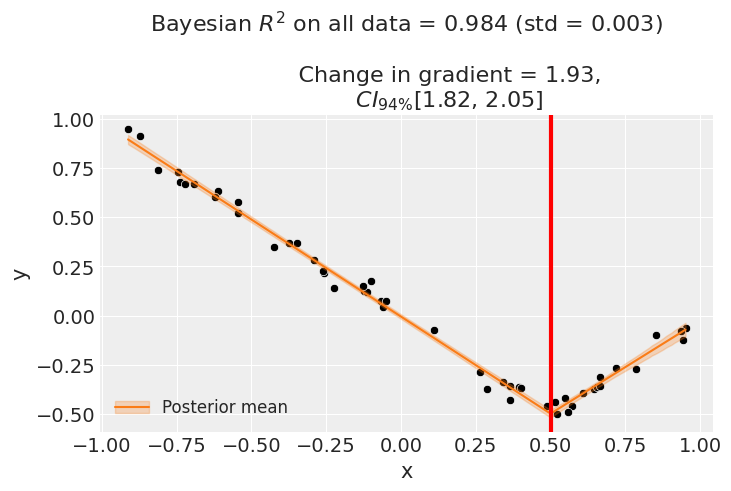

In [5]:
result = cp.pymc_experiments.RegressionKink(
    df,
    formula=f"y ~ 1 + x + I((x-{kink})*treated)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.1,
)

fig, ax = result.plot()
plt.savefig(
    image_path + "regression_kink_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

## Synthetic control

In [10]:
df = cp.load_data("sc")
treatment_time = 70

In [11]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


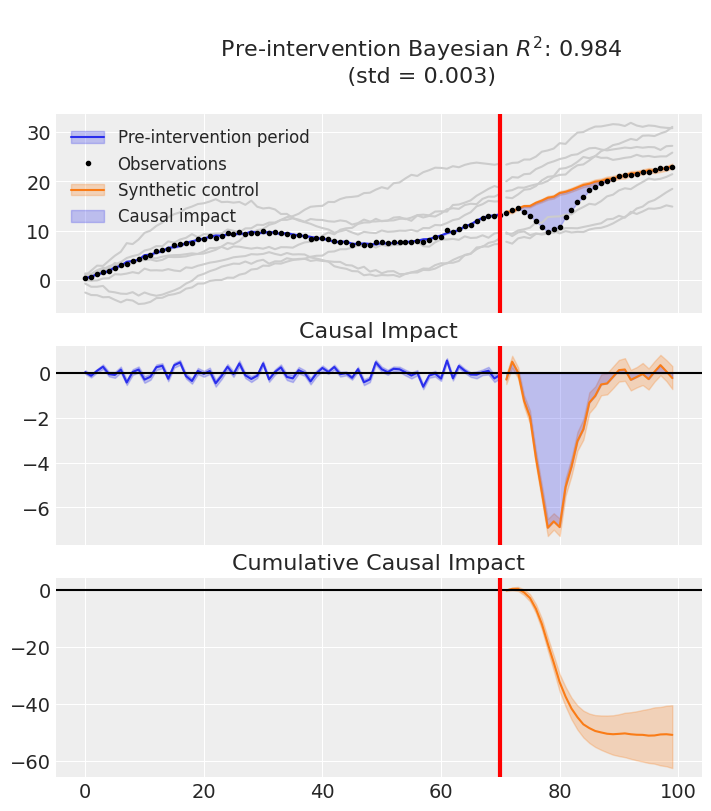

In [12]:
fig, ax = result.plot(plot_predictors=True)
plt.savefig(
    image_path + "synthetic_control_pymc.svg", bbox_inches="tight", pad_inches=0.1
)

## Interrupted time series

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


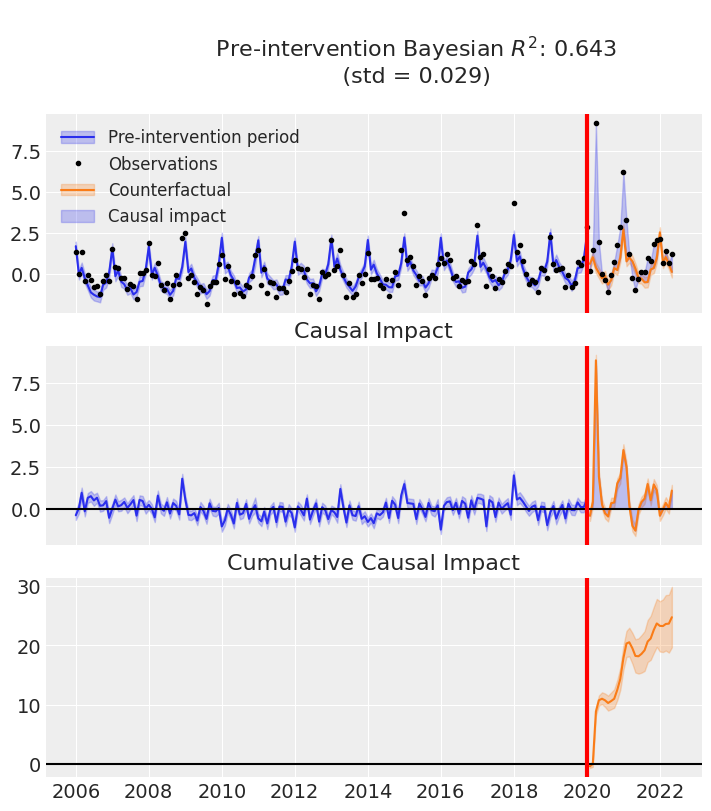

In [13]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2020-01-01")

result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

fig, ax = result.plot()
plt.savefig(
    image_path + "interrupted_time_series_pymc.svg", bbox_inches="tight", pad_inches=0.1
)